In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import os
os.listdir()


In [ ]:
import pandas as pd
df = pd.read_excel("data_clean.xlsx")


Saving data_clean.xlsx to data_clean (1).xlsx


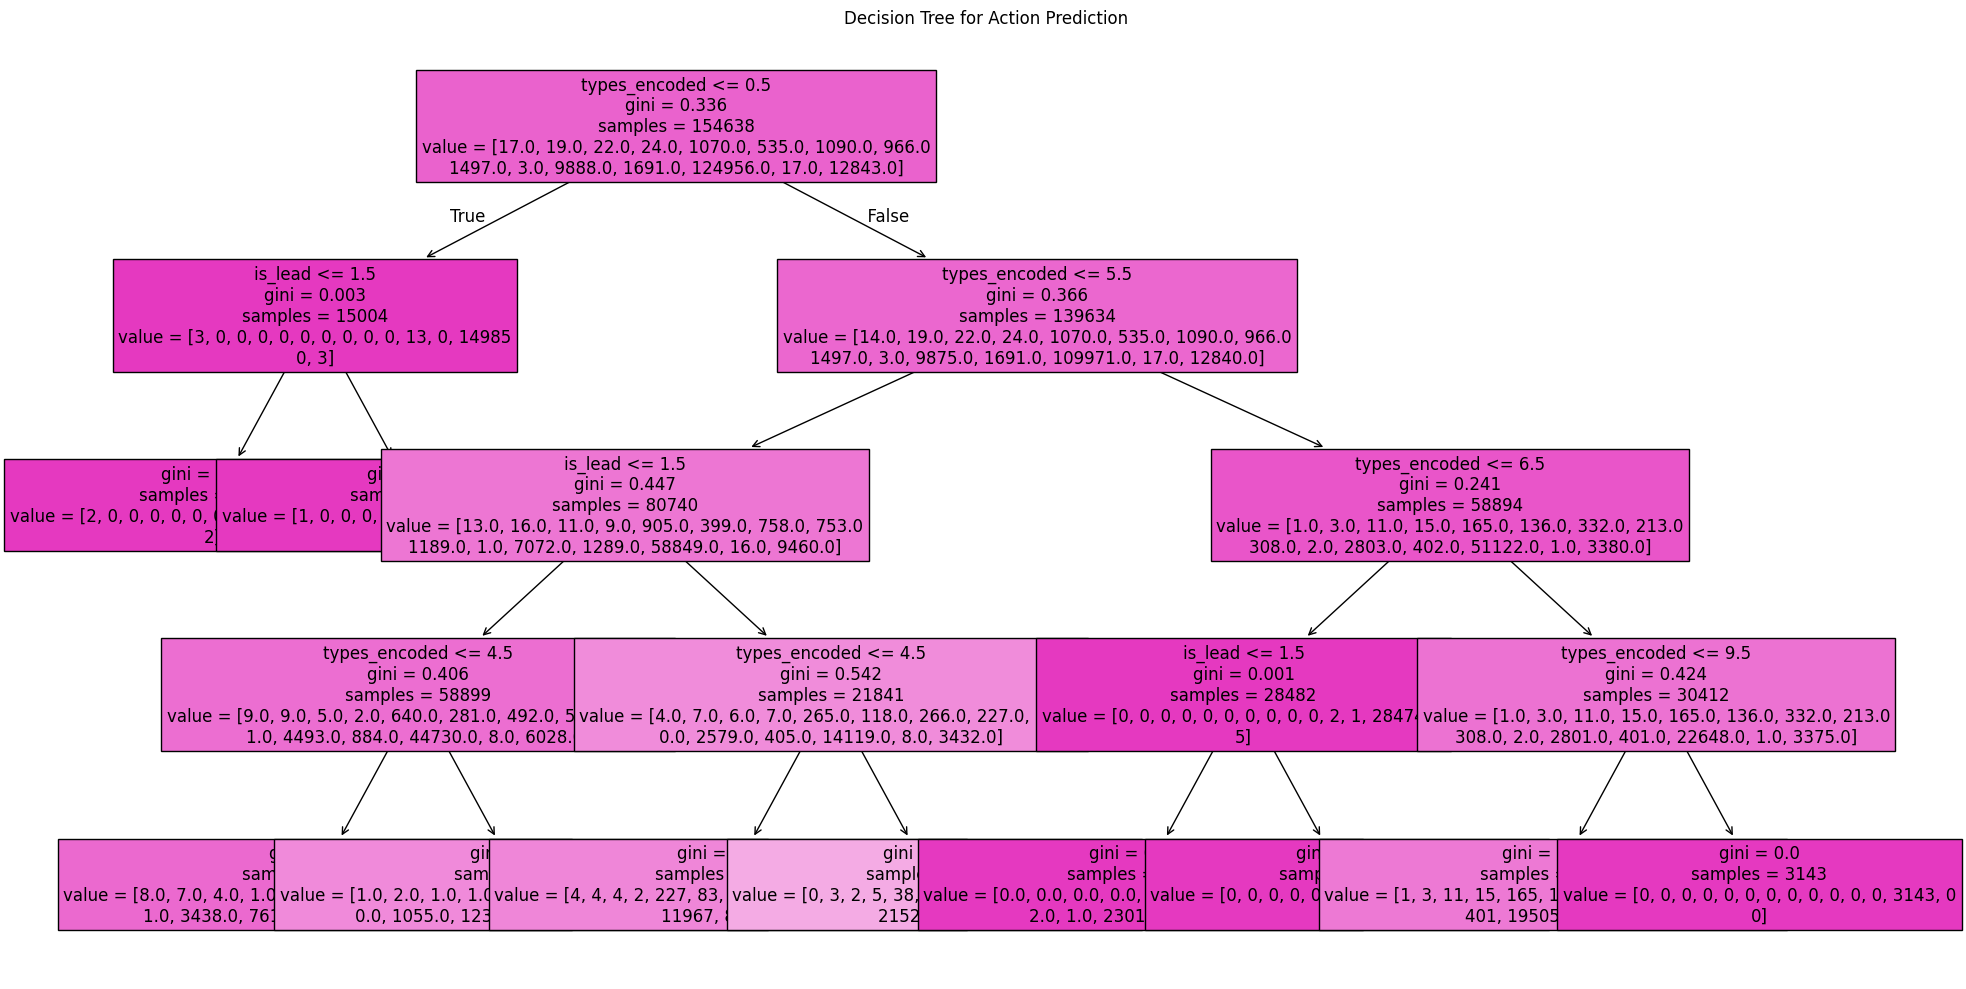

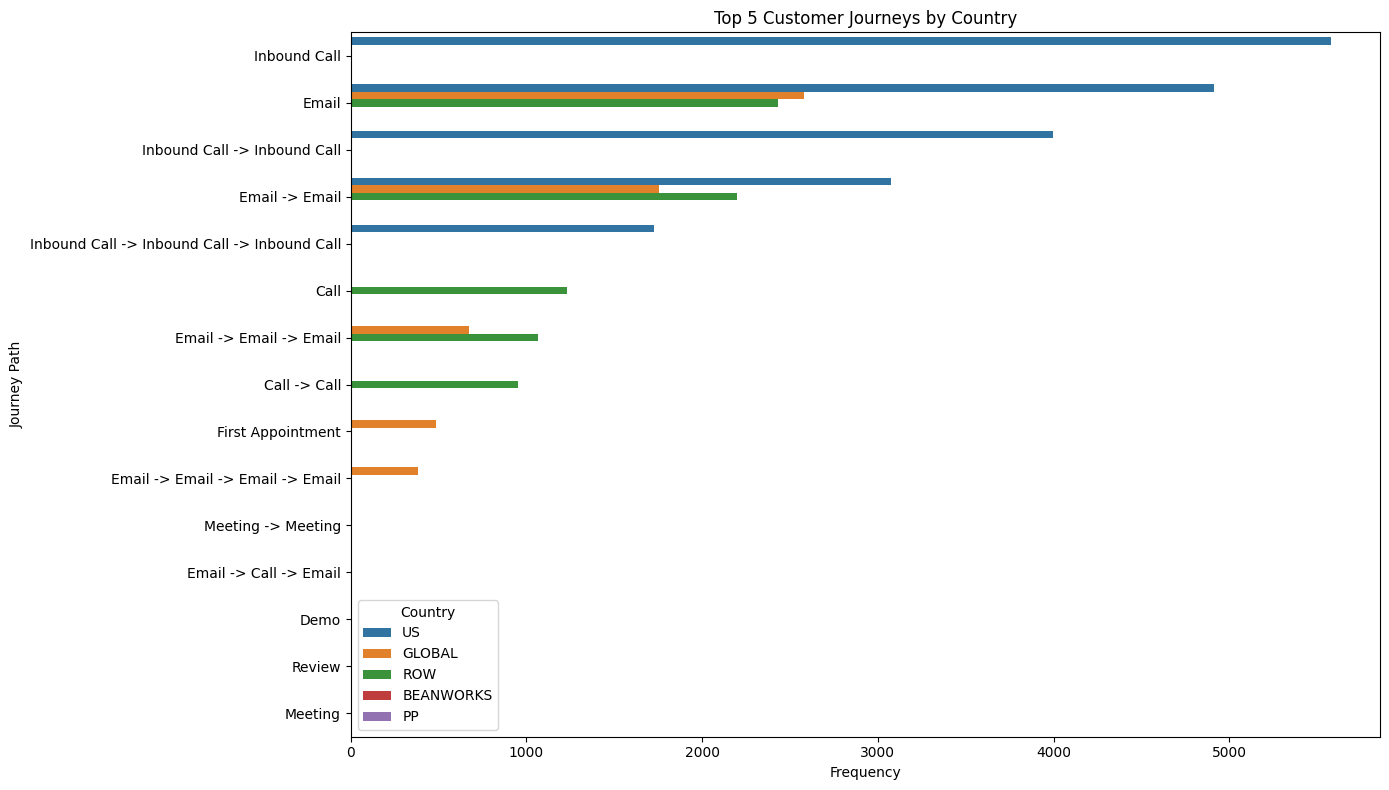

Top 4 actions by country (US):
types
Email           36065
Inbound Call    28481
Meeting         16045
Follow Up       10001
Name: count, dtype: int64
Top 4 actions by solution (CRM):
Series([], Name: count, dtype: int64)
Top 4 actions by country and solution (US, CRM):
Series([], Name: count, dtype: int64)
Top 4 actions after adding new action:
Series([], Name: count, dtype: int64)
Predicted next stage: 12.0
Predicted outcome (Win/Loss) for the action 'Inbound Call':
Loss


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but OrdinalEncoder was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but OrdinalEncoder was fitted with feature names



In [2]:

!pip install pandas scikit-learn matplotlib seaborn plotly


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OrdinalEncoder
from google.colab import files


uploaded = files.upload()


df = pd.read_excel("data_clean.xlsx")



for col in ['types', 'opportunity_stage', 'SourceSystem']:
    df[col] = df[col].fillna('unknown')


df['is_lead'] = pd.to_numeric(df['is_lead'], errors='coerce')
df['is_lead'] = df['is_lead'].fillna(0).astype(int)


df['activity_date'] = pd.to_datetime(df['activity_date'], errors='coerce')
df['activity_date'] = df['activity_date'].fillna(pd.Timestamp('1900-01-01'))


df['country'] = df['SourceSystem'].str.split('_').str[-1]


encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(df[['types', 'opportunity_stage']])
df[['types_encoded', 'stage_encoded']] = encoder.transform(df[['types', 'opportunity_stage']])


df = df.dropna(subset=['types_encoded', 'stage_encoded'])


X = df[['types_encoded', 'is_lead']]
y = df['stage_encoded']
clf = DecisionTreeClassifier(max_depth=4)
clf.fit(X, y)


plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=['types_encoded', 'is_lead'], filled=True, fontsize=12)
plt.title("Decision Tree for Action Prediction")
plt.tight_layout()
plt.show()


def get_top_actions(df, country=None, solution=None):
    subset = df.copy()
    if country:
        subset = subset[subset['country'] == country]
    if solution:
        subset = subset[subset['SourceSystem'].str.contains(solution)]
    return subset['types'].value_counts().head(4)


def predict_next_stage(action_type, is_lead):
    encoded = encoder.transform([[action_type, 'unknown']])
    action_encoded = encoded[0][0]


    input_df = pd.DataFrame([[action_encoded, is_lead]], columns=['types_encoded', 'is_lead'])
    return clf.predict(input_df)[0]


def update_weights_and_retrain(new_action, country=None, solution=None, is_lead=0):

    new_row = pd.DataFrame({'types': [new_action], 'country': [country], 'SourceSystem': [solution], 'is_lead': [is_lead]})
    global df
    df = pd.concat([df, new_row], ignore_index=True)


    df = df.dropna(subset=['types_encoded', 'stage_encoded'])


    encoder.fit(df[['types', 'opportunity_stage']])
    df[['types_encoded', 'stage_encoded']] = encoder.transform(df[['types', 'opportunity_stage']])

    X = df[['types_encoded', 'is_lead']]
    y = df['stage_encoded']
    clf.fit(X, y)

    top_actions = get_top_actions(df, country=country, solution=solution)


    predicted_stage = predict_next_stage(new_action, is_lead)

    return top_actions, predicted_stage

# تحليل المسارات (Customer Journeys)
df['path'] = df.groupby(['country', 'who_id'])['types'].transform(lambda x: ' -> '.join(x))
top_paths = df.groupby(['country', 'path']).size().reset_index(name='count')
top_paths = top_paths.sort_values('count', ascending=False).groupby('country').head(5)

plt.figure(figsize=(14, 8))
sns.barplot(data=top_paths, x='count', y='path', hue='country')
plt.title("Top 5 Customer Journeys by Country")
plt.xlabel("Frequency")
plt.ylabel("Journey Path")
plt.legend(title='Country')
plt.tight_layout()
plt.show()

def plot_actions_plotly(df, country):
    actions = df[df['country'] == country]['types'].value_counts().reset_index()
    actions.columns = ['Action', 'Count']
    fig = px.bar(actions, x='Action', y='Count', title=f"Top 5 Actions in {country}", color='Action')
    fig.show()

plot_actions_plotly(df, 'US')


def predict_win_or_loss(action_type, is_lead):
    predicted_stage = predict_next_stage(action_type, is_lead)
    return "Win" if predicted_stage == 1 else "Loss"


def display_top_actions(df, country=None, solution=None):

    top_by_country = get_top_actions(df, country=country) if country else None


    top_by_solution = get_top_actions(df, solution=solution) if solution else None


    top_by_country_solution = get_top_actions(df, country=country, solution=solution) if country and solution else None

    if top_by_country is not None:
        print(f"Top 4 actions by country ({country}):")
        print(top_by_country)

    if top_by_solution is not None:
        print(f"Top 4 actions by solution ({solution}):")
        print(top_by_solution)

    if top_by_country_solution is not None:
        print(f"Top 4 actions by country and solution ({country}, {solution}):")
        print(top_by_country_solution)


country_input = 'US'
solution_input = 'CRM'
display_top_actions(df, country=country_input, solution=solution_input)


new_action = "Outbound Email"
top_actions, predicted_stage = update_weights_and_retrain(new_action, country=country_input, solution=solution_input, is_lead=1)


print("Top 4 actions after adding new action:")
print(top_actions)
print("Predicted next stage:", predicted_stage)


action_type = 'Inbound Call'
print("Predicted outcome (Win/Loss) for the action 'Inbound Call':")
print(predict_win_or_loss(action_type, is_lead=1))